In [1]:
from riskyneuroarousal.utils.load_data import load_behavioral_data
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [116]:
from scipy.optimize import curve_fit

# Define the function
def sigmoid_like(x, alpha, beta):
    return 1 / (1 + alpha * np.exp(beta * x))
def fit_sigmoid(x_data, y_data):
    # Fit the sigmoid function to the data
    params, covariance = curve_fit(sigmoid_like, x_data, y_data, p0=[1, 1])  # Initial guess for alpha and beta
    return params

In [2]:
behavioral_data = load_behavioral_data(min_RT = 0.2)
equalIndiff = behavioral_data.query("condition == 'equalIndifference'")
equalRange = behavioral_data.query("condition == 'equalRange'")

In [140]:
blocks = []
trial_num = 16
for i in range(16):
    trial_data = equalRange.query("trial <= @trial_num + @trial_num*@i & trial > @i*@trial_num")
    responses = equalRange[["gain", "loss"]].drop_duplicates().reset_index(drop=True)
    responses["accept"] = 0
    responses["weak_accept"] = 0
    responses["weak_reject"] = 0
    responses["reject"] = 0

    for index, row in trial_data.iterrows():
        gain, loss, accept = row["gain"], row["loss"], row["response_int"]
        if accept == 1:
            responses.loc[(responses["gain"] <= gain) & (responses["loss"] >= loss), "reject"] += 1
        elif accept == 2:
            responses.loc[(responses["gain"] <= gain) & (responses["loss"] >= loss), "weak_reject"] += 1
        elif accept == 3:
            responses.loc[(responses["gain"] >= gain) & (responses["loss"] <= loss), "weak_accept"] += 1
        elif accept == 4:
            responses.loc[(responses["gain"] >= gain) & (responses["loss"] <= loss), "accept"] += 1
    responses["block"] = i + 1
    blocks.append(responses)
responses = pd.concat(blocks)


In [141]:
responses["prob"] = (responses["accept"] + 2/3*responses["weak_accept"] + 1/3*responses["weak_reject"] + 0*responses["reject"]) / (responses["accept"] + responses["weak_accept"] + responses["weak_reject"] + responses["reject"])
responses["diff"] = np.log(responses["gain"] / responses["loss"])
# remove any rows where prob is nan
responses = responses[~responses["prob"].isna()]

In [142]:
alphas1, betas1 = [], []
for b in responses["block"].unique():
    block_data = responses.query("block == @b")
    x_data = block_data["diff"].values
    y_data = block_data["prob"].values

    # Fit the sigmoid function to the data
    params = fit_sigmoid(x_data, y_data)
    alpha, beta = params
    alphas1.append(alpha)
    betas1.append(beta)

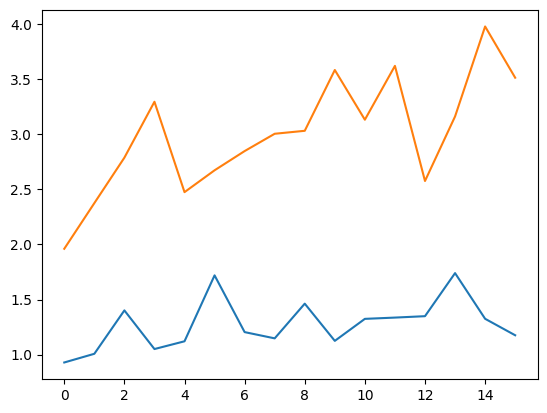

In [143]:
plt.plot(alphas1, label="alpha1")
plt.plot(alphas2, label="alpha2")

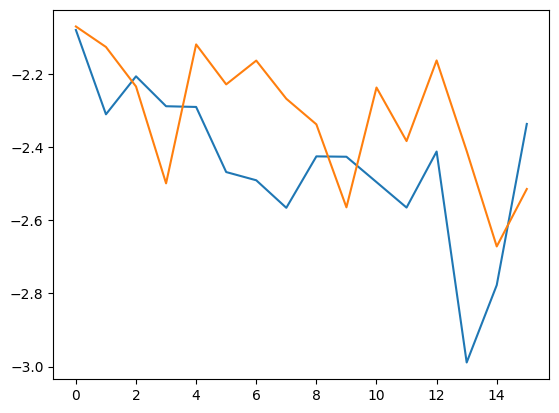

In [144]:
plt.plot(betas1, label="alpha1")
plt.plot(betas2, label="alpha2")

In [126]:
y_data[np.isnan(y_data)]

array([nan])

In [64]:
%load_ext rpy2.ipython

In [112]:
%%R -i responses
library(lme4)
library(lmerTest)

/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/.venv/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [113]:
%%R -o estimates_df
# for each unique block
unique_blocks = unique(responses$block)
names <- c()
estimates <- c()
blocks <- c()

# loop through blocks
for (block in unique_blocks) {
    block_data = responses[responses$block == block, ]
    model <- lm(prob ~ gain + loss, data = block_data)
    
    fixed_effects <- summary(model)$coefficients
    # extract the estimates and names
    estimates <- c(estimates, fixed_effects[, 1])
    names <- c(names, rownames(fixed_effects))
    blocks <- c(blocks, rep(block, nrow(fixed_effects)))
}

# create a data frame with the estimates and names
estimates_df <- data.frame(block = blocks, names = names, estimates = estimates)
    # filter the data for the current block
    # 
    
    # # fit the model
    # 
    
    # # print the summary of the model
    #

In [114]:
gain1 = estimates_df.query("names == 'gain'")["estimates"].values
loss1 = np.abs(estimates_df.query("names == 'loss'")["estimates"].values)

In [107]:
gain2 = estimates_df.query("names == 'gain'")["estimates"].values
loss2 = np.abs(estimates_df.query("names == 'loss'")["estimates"].values)

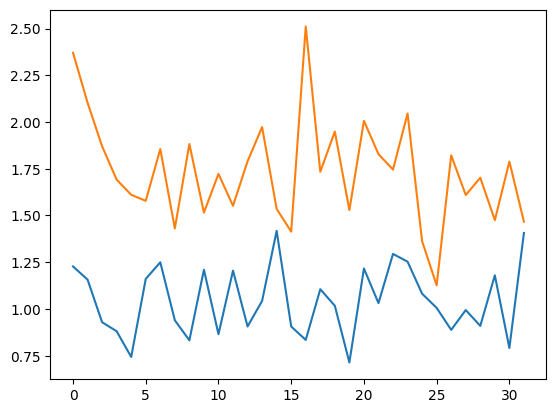

In [115]:
plt.plot(loss1/gain1)
plt.plot(loss2/gain2)

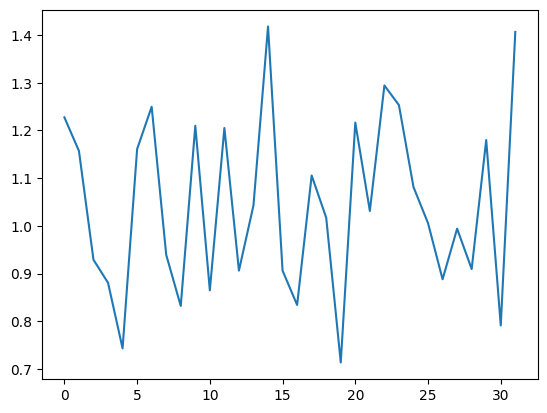

In [102]:
plt.plot(loss/gain)

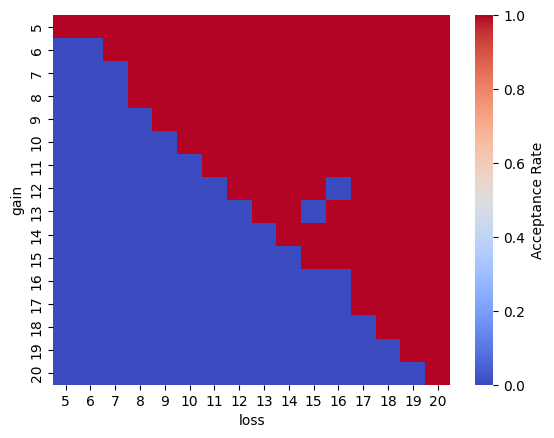

In [3]:
hmap_data = equalRange.query("sub == 56").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'})
plt.show()

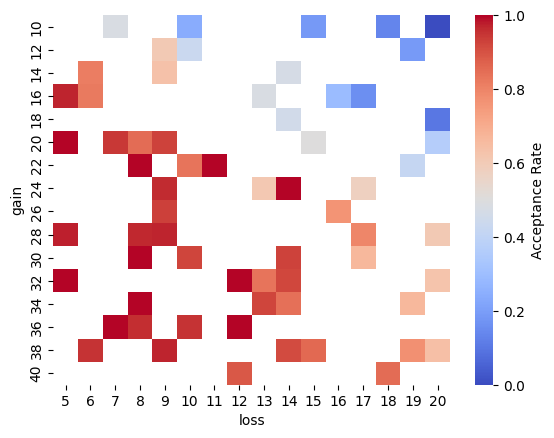

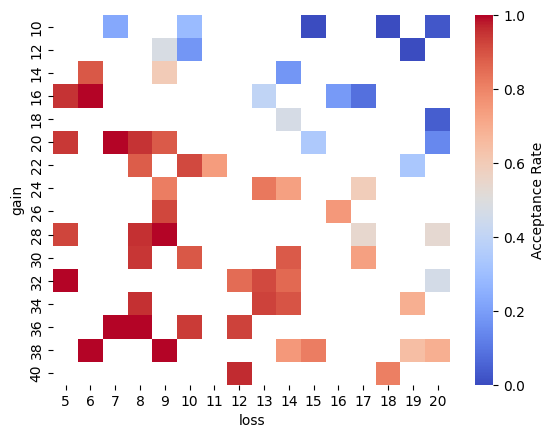

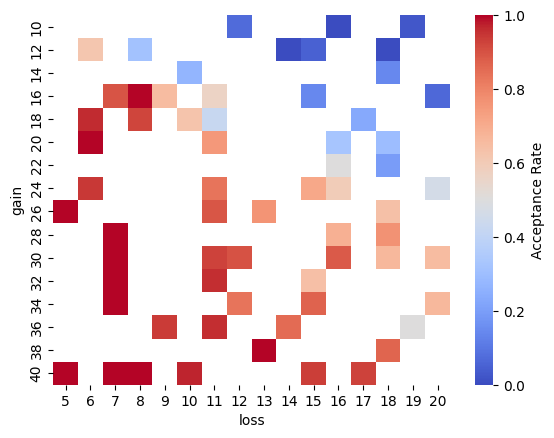

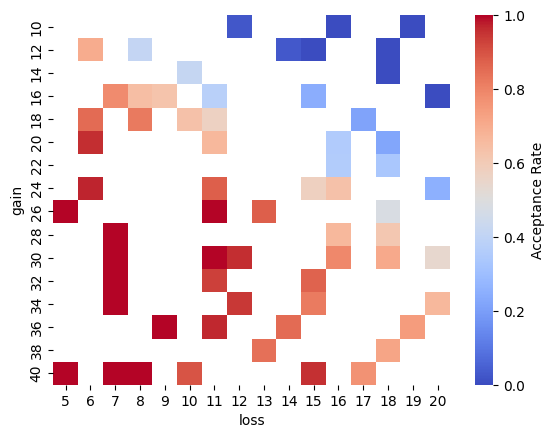

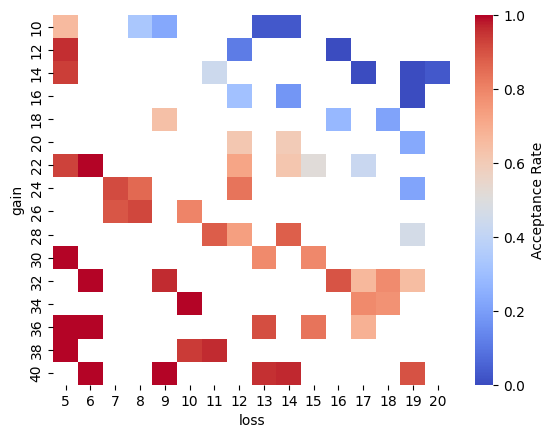

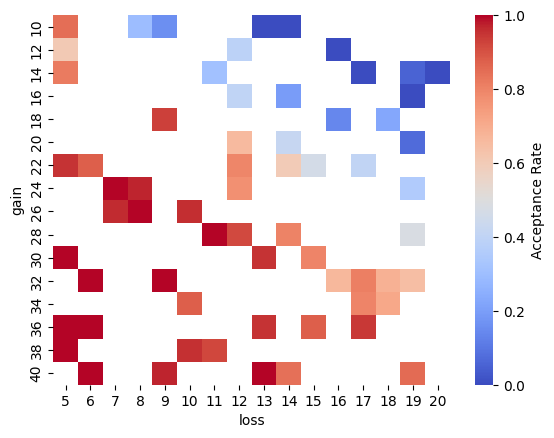

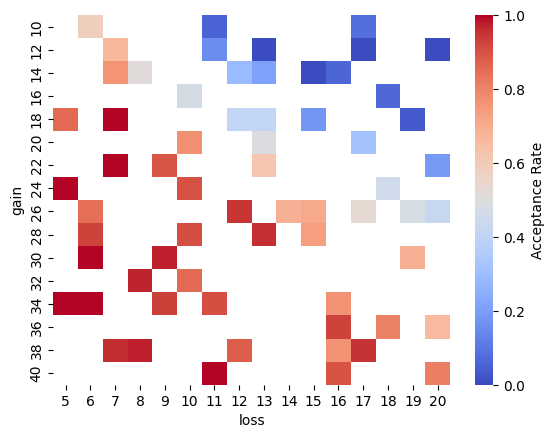

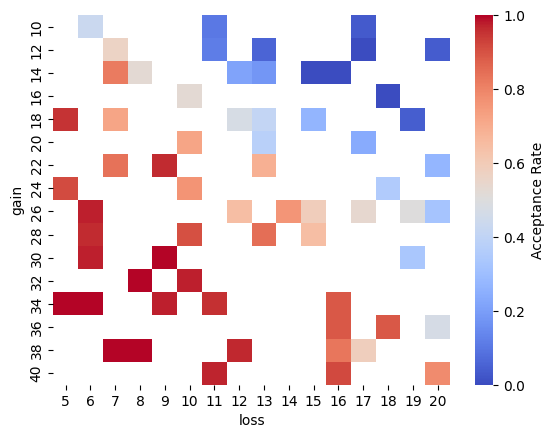

In [17]:
trial_num = 32
for i in range(8):
    trial_data = equalIndiff.query("trial <= @trial_num + 32*@i & trial > @i*@trial_num")
    hmap_data = trial_data.groupby(['gain', 'loss'])['accept'].mean().unstack()
    sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'})
    plt.show()
                




In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("condition == 'equalRange'").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[0])
axs[0].set_title("Low reward environment")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[1])
axs[1].set_title("High reward environment")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()